In [0]:
from pyspark.sql.functions import col, lit, floor, when, concat_ws, to_timestamp, lpad, lag, lead, avg, hour, dayofyear
from pyspark.sql.window import Window
from pyspark.sql import Row
from datetime import datetime, timedelta
import pyspark.pandas as ps
import re
import numpy as np
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor, LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

In [0]:
cities_list = ['Amsterdam', 'Copenhagen', 'Dublin', 'Antwerp']
api_forecasts_df = spark.read.parquet('/mnt/de-upskilling-weather/Gold/7day_hourly_forecast.parquet/').where(col('city').isin(cities_list)).select('date', 'city', 'temperature_2m', 'dew_point_2m', 'shortwave_radiation', 'surface_pressure', 'pressure_msl', 'cloud_cover', 'relative_humidity_2m').orderBy('city','date')

In [0]:
# loading in hourly historical data
hourly_historical = spark.read.parquet('/mnt/de-upskilling-weather/Gold/hourly_historical.parquet/').where(col('city').isin(cities_list))

hourly_historical = hourly_historical.select('city', 'year', 'month', hour('datetime').alias('hour'), 'datetime', 'temperature_2m', 'dew_point_2m', 'shortwave_radiation', 'surface_pressure', 'pressure_msl', 'cloud_cover') 

hourly_historical = hourly_historical.withColumn('datetime', to_timestamp('datetime')).withColumn('day_of_year', dayofyear('datetime'))

hourly_historical = hourly_historical.withColumn("season", when(col("month").isin([12, 1, 2]), 0)
                         .when(col("month").isin([3, 4, 5]), 1)
                         .when(col("month").isin([6, 7, 8]), 2)
                         .otherwise(3))

In [0]:
feature_columns = ['temp_lag_1hr', 'rolling_temp_avg3hr', 'temp_lag_3hr', 'rolling_temp_avg6hr', 'dew_point_2m', 'season', 'shortwave_radiation', 'month', 'day_of_year', 'pressure_msl', 'surface_pressure', 'hour', 'cloud_cover', 'temp_lag_1day', 'rolling_temp_avg1day']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# GBT works a lot better than RFR
gbt = GBTRegressor(labelCol="temperature_2m", featuresCol="features", maxIter=150, maxDepth=7, stepSize=0.05)
lr = LinearRegression(labelCol="temperature_2m", featuresCol="features")
rfr = RandomForestRegressor(labelCol="temperature_2m", featuresCol="features", maxDepth=7, numTrees=100)

In [0]:
# lag and rolling windows
lag_window = Window.orderBy('datetime')
rolling_window_3hr = Window.orderBy('datetime').rowsBetween(-3, -1)
rolling_window_6hr = Window.orderBy('datetime').rowsBetween(-6, -1)
rolling_window_12hr = Window.orderBy('datetime').rowsBetween(-12, -1)
rolling_window_24hr = Window.orderBy('datetime').rowsBetween(-24, -1) 

In [0]:
month_to_season = {
    12: 0, 1: 0, 2: 0,  # Winter
    3: 1, 4: 1, 5: 1,  # Spring
    6: 2, 7: 2, 8: 2,  # Summer
    9: 3, 10: 3, 11: 3  # Fall
}

In [0]:
city = 'Copenhagen'
city_no_ws = re.sub(r'\W+', '', city)

In [0]:
# Model Generation
city_no_ws = re.sub(r'\W+', '', city)
#model_path = f'/mnt/de-upskilling-weather/MachineLearning/{city_no_ws}_forecast_model'
# getting dataset for specific city
df = hourly_historical.where(col('city') == city)
df = df.drop('city').orderBy('datetime')

# temperature lags
df = df.withColumn('temp_lag_1hr', lag('temperature_2m', 1).over(lag_window))
df = df.withColumn('temp_lag_3hr', lag('temperature_2m', 3).over(lag_window))
df = df.withColumn('temp_lag_1day', lag('temperature_2m', 24).over(lag_window))

# temperature rolling averages
df = df.withColumn('rolling_temp_avg3hr', avg('temperature_2m').over(rolling_window_3hr))
df = df.withColumn('rolling_temp_avg6hr', avg('temperature_2m').over(rolling_window_6hr))
df = df.withColumn('rolling_temp_avg1day', avg('temperature_2m').over(rolling_window_24hr))


# dropping all nulls created from lags
df = df.dropna()

# vectorizing features, generating model, and saving model
train_data = assembler.transform(df).select('features', 'temperature_2m')
forecast_model = rfr.fit(train_data)

# forecast_model.write().overwrite().save(model_path)

In [0]:
# Forecast Generation
# removing whitespace and reading in dataframe
city_no_ws = re.sub(r'\W+', '', city)
df = spark.read.parquet(f'/mnt/de-upskilling-weather/Silver/Forecast_Data/{city_no_ws}_forecast_data.parquet/').withColumn('datetime', to_timestamp('datetime'))
#model_path = f'/mnt/de-upskilling-weather/MachineLearning/{city_no_ws}_forecast_model'
api_forecast = api_forecasts_df.where(col('city') == city)

# generating temperature list and converting to np array
temp_list = df.select('temperature_2m').rdd.flatMap(lambda x: x).collect()
np_temp_list = np.array(temp_list)

# loading model
model = forecast_model

# used to create forecast dataframe after
ts_list = []
temp_preds = []

# using latest timestamp to generate last row df and keep track
current_ts = df.tail(1)[0]['datetime'] + timedelta(hours=1)

# API forecast variables
api_forecast = api_forecasts_df.where((col('city') == city) & (col('date') >= current_ts))

dew_point_2m_list = api_forecast.select('dew_point_2m').rdd.flatMap(lambda x: x).collect()
shortwave_radiation_list = api_forecast.select('shortwave_radiation').rdd.flatMap(lambda x: x).collect()
surface_pressure_list = api_forecast.select('surface_pressure').rdd.flatMap(lambda x: x).collect()
pressure_msl_list = api_forecast.select('pressure_msl').rdd.flatMap(lambda x: x).collect()
relative_humidity_2m_list = api_forecast.select('relative_humidity_2m').rdd.flatMap(lambda x: x).collect()
cloud_cover_list = api_forecast.select('cloud_cover').rdd.flatMap(lambda x: x).collect()

for i in range(168):
    # generating new row
    new_row = Row(month=current_ts.month, 
                hour=current_ts.hour,
                datetime=current_ts,
                day_of_year=current_ts.timetuple()[7],
                season=month_to_season[current_ts.month],
                temp_lag_1hr=float(np_temp_list[-1]),
                temp_lag_3hr=float(np_temp_list[-3]),
                temp_lag_1day=float(np_temp_list[-24]),
                rolling_temp_avg3hr=float(np.average(np_temp_list[-3:])),
                rolling_temp_avg6hr=float(np.average(np_temp_list[-6:])),
                rolling_temp_avg1day=float(np.average(np_temp_list[-24:])),
                temperature_2m=float('nan'),
                dew_point_2m=dew_point_2m_list[i],
                shortwave_radiation=shortwave_radiation_list[i],
                pressure_msl=pressure_msl_list[i],
                surface_pressure=surface_pressure_list[i],
                relative_humidity_2m=relative_humidity_2m_list[i],
                cloud_cover=cloud_cover_list[i]
                )
    current_row_df = spark.createDataFrame([new_row])
    # print(current_row_df.select('datetime', 'season', 'day_of_year', 'temp_lag_1hr', 'temp_lag_3hr', 'rolling_temp_avg3hr', 'rolling_temp_avg6hr').collect())

    # applying model and getting prediction
    prediction_data = assembler.transform(current_row_df).select('features', 'temperature_2m')

    prediction = model.transform(prediction_data)
    temp_pred = prediction.tail(1)[0][2]

    np_temp_list = np.append(np_temp_list[1:], temp_pred)

    # adding an hour to latest_ts
    ts_list.append(current_ts)
    temp_preds.append(temp_pred)
    current_ts = current_ts + timedelta(hours=1)

forecast_df = spark.createDataFrame(list(zip(ts_list, temp_preds)), schema=['timestamp', 'pred_temp'])
# forecast_df.write.mode('overwrite').parquet(f'/mnt/de-upskilling-weather/Silver/Forecasts/{city_no_ws}_forecast.parquet/')
print(f'finished with {city}')

finished with Copenhagen


In [0]:
join_df = api_forecasts_df.withColumnRenamed('date', 'timestamp').select('temperature_2m', 'timestamp', 'city', 'dew_point_2m', 'shortwave_radiation','surface_pressure', 'pressure_msl', 'cloud_cover','relative_humidity_2m').where(col('city') == city)
forecast_comparison = forecast_df.join(join_df, on=['timestamp'], how='inner')

# Linear Regression Results

In [0]:
display(forecast_comparison)

timestamp,pred_temp,temperature_2m,city,dew_point_2m,shortwave_radiation,surface_pressure,pressure_msl,cloud_cover,relative_humidity_2m
2025-01-20T00:00:00Z,-0.2700187459134278,-0.2370000034570694,Copenhagen,-0.6554757356643677,0.0,1021.920166015625,1023.2000122070312,100.0,97.0
2025-01-20T01:00:00Z,-0.5313998313357668,-0.4869999885559082,Copenhagen,-0.9046152234077454,0.0,1021.519287109375,1022.7999877929688,100.0,97.0
2025-01-20T02:00:00Z,-0.35002802105512165,-0.18700000643730164,Copenhagen,-0.6056479215621948,0.0,1020.921630859375,1022.2000122070312,100.0,97.0
2025-01-20T03:00:00Z,-0.03670535717181567,0.11300000548362732,Copenhagen,-0.30668196082115173,0.0,1020.5234375,1021.7999877929688,100.0,97.0
2025-01-20T04:00:00Z,0.5937243129125029,0.8130000233650208,Copenhagen,0.39090025424957275,0.0,1019.9273681640625,1021.2000122070312,100.0,97.0
2025-01-20T05:00:00Z,1.0026428422597855,1.062999963760376,Copenhagen,0.6400350332260132,0.0,1019.6290893554688,1020.9000244140625,99.0,97.0
2025-01-20T06:00:00Z,1.1140164313054686,1.1629999876022339,Copenhagen,0.45098742842674255,0.0,1019.2297973632812,1020.5,98.0,95.0
2025-01-20T07:00:00Z,1.0720633983224017,1.062999963760376,Copenhagen,0.2053130865097046,0.0,1019.0298461914062,1020.2999877929688,100.0,94.0
2025-01-20T08:00:00Z,1.0725518449051108,1.1130000352859497,Copenhagen,0.2549622654914856,4.0,1018.9302368164062,1020.2000122070312,22.0,94.0
2025-01-20T09:00:00Z,1.1474805051370152,1.2130000591278076,Copenhagen,0.20643767714500427,32.0,1018.8306884765625,1020.0999755859375,25.0,93.0


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="temperature_2m", predictionCol="pred_temp", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="temperature_2m", predictionCol="pred_temp", metricName="r2")

rmse = evaluator_rmse.evaluate(forecast_comparison)
r2 = evaluator_r2.evaluate(forecast_comparison)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 value (R2): {r2}\n")

Root Mean Squared Error (RMSE): 25.32521588118918
R^2 value (R2): -234.60136289545338



/databricks/spark/python/pyspark/pandas/plot/matplotlib.py:858: FutureWarning: Argument `sort_columns` will be removed in 4.0.0.
  warnings.warn(


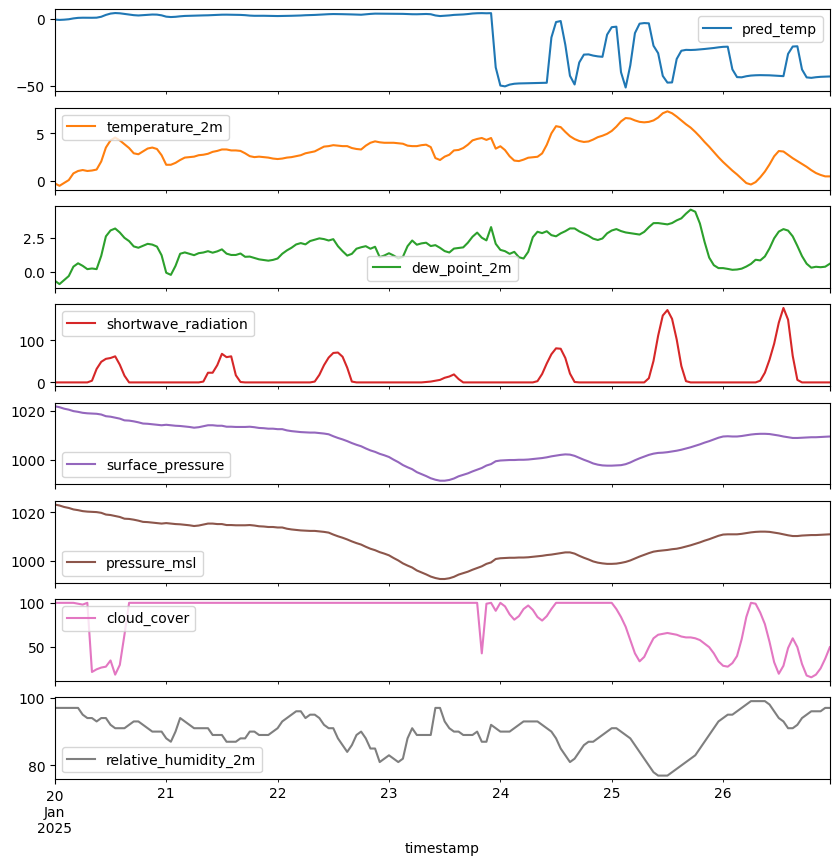

In [0]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt

# Set the plotting backend to matplotlib
ps.options.plotting.backend = "matplotlib"

results_pandas = forecast_comparison.pandas_api()
results_pandas.plot(x='timestamp', kind='line', subplots=True, figsize=(10, 10))
plt.show()

# Random Forest Regressor Results

In [0]:
display(forecast_comparison)

timestamp,pred_temp,temperature_2m,city,dew_point_2m,shortwave_radiation,surface_pressure,pressure_msl,cloud_cover,relative_humidity_2m
2025-01-20T00:00:00Z,-0.035199462493428445,-0.2370000034570694,Copenhagen,-0.6554757356643677,0.0,1021.920166015625,1023.2000122070312,100.0,97.0
2025-01-20T01:00:00Z,-0.035199462493428445,-0.4869999885559082,Copenhagen,-0.9046152234077454,0.0,1021.519287109375,1022.7999877929688,100.0,97.0
2025-01-20T02:00:00Z,-0.03910051168300469,-0.18700000643730164,Copenhagen,-0.6056479215621948,0.0,1020.921630859375,1022.2000122070312,100.0,97.0
2025-01-20T03:00:00Z,0.13319577453594464,0.11300000548362732,Copenhagen,-0.30668196082115173,0.0,1020.5234375,1021.7999877929688,100.0,97.0
2025-01-20T04:00:00Z,0.3223634761622528,0.8130000233650208,Copenhagen,0.39090025424957275,0.0,1019.9273681640625,1021.2000122070312,100.0,97.0
2025-01-20T05:00:00Z,0.3223634761622528,1.062999963760376,Copenhagen,0.6400350332260132,0.0,1019.6290893554688,1020.9000244140625,99.0,97.0
2025-01-20T06:00:00Z,0.31707663264923863,1.1629999876022339,Copenhagen,0.45098742842674255,0.0,1019.2297973632812,1020.5,98.0,95.0
2025-01-20T07:00:00Z,0.139956637699805,1.062999963760376,Copenhagen,0.2053130865097046,0.0,1019.0298461914062,1020.2999877929688,100.0,94.0
2025-01-20T08:00:00Z,0.2692033370558812,1.1130000352859497,Copenhagen,0.2549622654914856,4.0,1018.9302368164062,1020.2000122070312,22.0,94.0
2025-01-20T09:00:00Z,0.13761431445406866,1.2130000591278076,Copenhagen,0.20643767714500427,32.0,1018.8306884765625,1020.0999755859375,25.0,93.0


In [0]:
evaluator_rmse = RegressionEvaluator(labelCol="temperature_2m", predictionCol="pred_temp", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="temperature_2m", predictionCol="pred_temp", metricName="r2")

rmse = evaluator_rmse.evaluate(forecast_comparison)
r2 = evaluator_r2.evaluate(forecast_comparison)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 value (R2): {r2}\n")

Root Mean Squared Error (RMSE): 1.8707962453847793
R^2 value (R2): -0.28565506583044575



/databricks/spark/python/pyspark/pandas/plot/matplotlib.py:858: FutureWarning: Argument `sort_columns` will be removed in 4.0.0.
  warnings.warn(


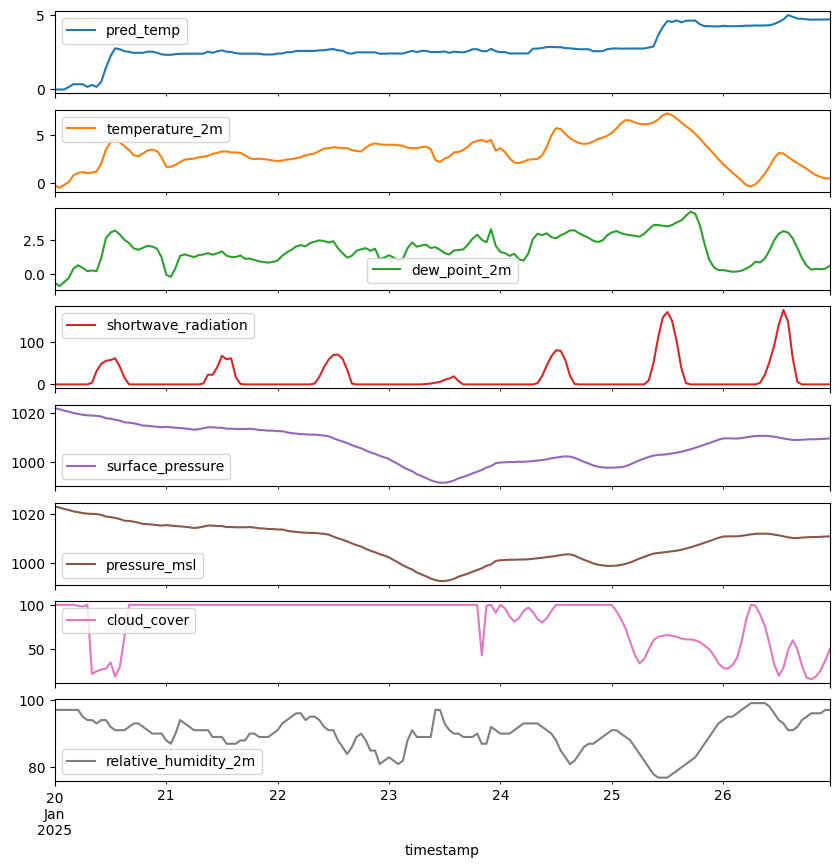

In [0]:
results_pandas = forecast_comparison.pandas_api()
results_pandas.plot(x='timestamp', kind='line', subplots=True, figsize=(10, 10))
plt.show()

# GBT Regressor Results

In [0]:
display(forecast_comparison)

timestamp,pred_temp,temperature_2m,city,dew_point_2m,shortwave_radiation,surface_pressure,pressure_msl,cloud_cover,relative_humidity_2m
2025-01-16T00:00:00Z,5.683573400226885,6.0370001792907715,Antwerp,5.744746208190918,0.0,1034.7935791015625,1035.300048828125,100.0,98.0
2025-01-16T01:00:00Z,6.2005167313904135,5.836999893188477,Antwerp,5.545214653015137,0.0,1034.5931396484375,1035.0999755859375,100.0,98.0
2025-01-16T02:00:00Z,6.426057338900328,5.436999797821045,Antwerp,5.292225360870361,0.0,1034.7923583984375,1035.300048828125,100.0,99.0
2025-01-16T03:00:00Z,6.361794454140389,5.13700008392334,Antwerp,4.992574691772461,0.0,1034.891845703125,1035.4000244140625,100.0,99.0
2025-01-16T04:00:00Z,6.4602468386792715,5.686999797821045,Antwerp,5.541933059692383,0.0,1035.0926513671875,1035.5999755859375,100.0,99.0
2025-01-16T05:00:00Z,6.343243376000105,5.686999797821045,Antwerp,4.948401927947998,0.0,1035.392578125,1035.9000244140625,100.0,95.0
2025-01-16T06:00:00Z,6.335626252552527,5.2870001792907715,Antwerp,4.8492841720581055,0.0,1035.491943359375,1036.0,100.0,97.0
2025-01-16T07:00:00Z,6.3325026653146645,4.836999893188477,Antwerp,4.547554016113281,0.0,1035.7908935546875,1036.300048828125,100.0,98.0
2025-01-16T08:00:00Z,6.331565000056357,4.936999797821045,Antwerp,4.3523640632629395,0.0,1036.1907958984375,1036.699951171875,100.0,96.0
2025-01-16T09:00:00Z,6.427907826264525,5.336999893188477,Antwerp,4.296233177185059,13.0,1036.491455078125,1037.0,100.0,93.0


In [0]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_rmse = RegressionEvaluator(labelCol="temperature_2m", predictionCol="pred_temp", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="temperature_2m", predictionCol="pred_temp", metricName="r2")

rmse = evaluator_rmse.evaluate(forecast_comparison)
r2 = evaluator_r2.evaluate(forecast_comparison)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 value (R2): {r2}\n")

Root Mean Squared Error (RMSE): 2.54213949599073
R^2 value (R2): -0.19194859373071527



/databricks/spark/python/pyspark/pandas/plot/matplotlib.py:858: FutureWarning: Argument `sort_columns` will be removed in 4.0.0.
  warnings.warn(


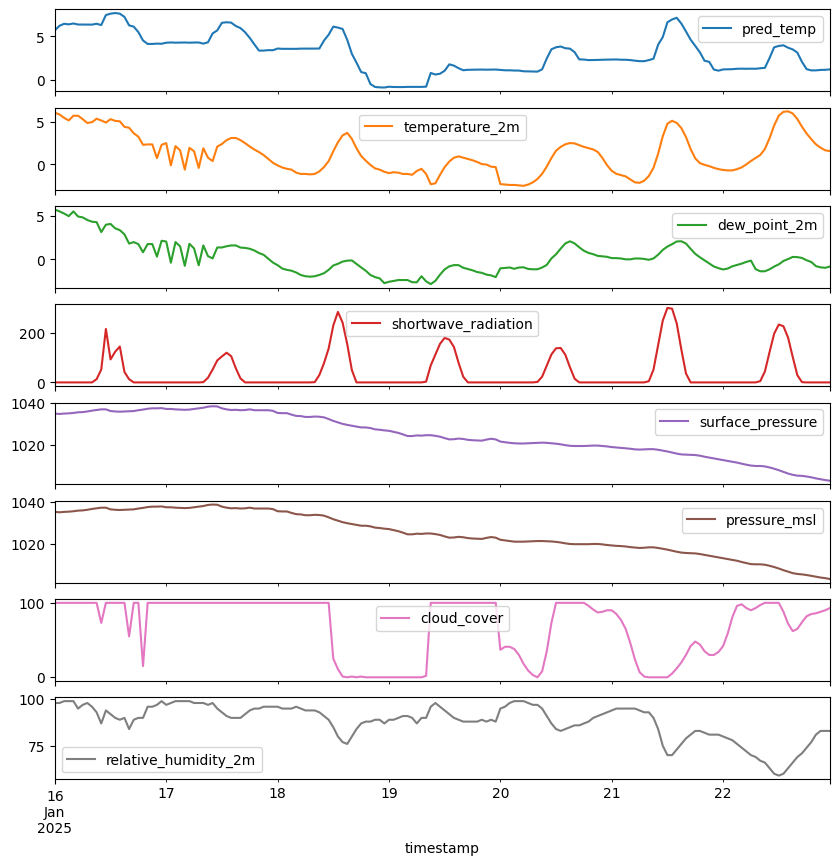

In [0]:
# generated GBT Regressor Forecast
import pyspark.pandas as ps
import matplotlib.pyplot as plt

# Set the plotting backend to matplotlib
ps.options.plotting.backend = "matplotlib"

results_pandas = forecast_comparison.pandas_api()
results_pandas.plot(x='timestamp', kind='line', subplots=True, figsize=(10, 10))
plt.show()